In [16]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, hour, avg, to_timestamp
import matplotlib.pyplot as plt
spark = SparkSession.builder \
    .appName("Humidity_Batch_Analysis_Final") \
    .config("spark.jars.packages", "org.apache.spark:spark-sql-kafka-0-10_2.12:3.5.0,org.apache.hadoop:hadoop-aws:3.3.4,com.amazonaws:aws-java-sdk-bundle:1.12.262") \
    .config("spark.hadoop.fs.s3a.endpoint", "http://minio:9000") \
    .config("spark.hadoop.fs.s3a.access.key", "minioadmin") \
    .config("spark.hadoop.fs.s3a.secret.key", "minioadmin") \
    .config("spark.hadoop.fs.s3a.path.style.access", "true") \
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .getOrCreate()

In [17]:
s3_path_hum = "s3a://humidity-data/topics/humidity-sensors/partition=0/*.json"


🌙 Análisis de Ciclo Día/Noche (Humedad):
+-----------+-----------------+
|hour_of_day|     avg_humidity|
+-----------+-----------------+
|         16|47.48388349514563|
|         17|48.67799999999999|
|         20| 72.9845970836531|
+-----------+-----------------+



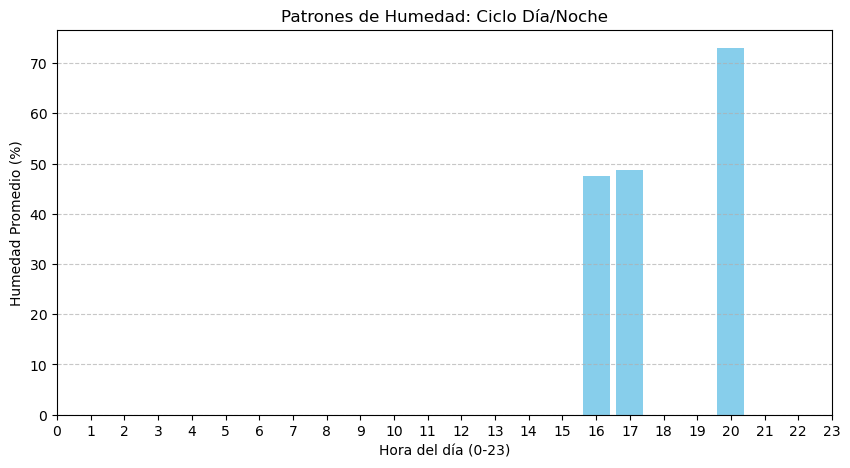

In [18]:
try:
    df_hum = spark.read.json(s3_path_hum)
    

    df_hum_processed = df_hum.withColumn("ts", to_timestamp(col("timestamp"))) \
                             .withColumn("hour_of_day", hour(col("ts")))

    print("Análisis de Ciclo Día/Noche (Humedad):")
    stats_hum = df_hum_processed.groupBy("hour_of_day") \
        .agg(avg("humidity").alias("avg_humidity")) \
        .orderBy("hour_of_day")

    stats_hum.show()


    pdf_hum = stats_hum.toPandas()
    plt.figure(figsize=(10, 5))
    plt.bar(pdf_hum['hour_of_day'], pdf_hum['avg_humidity'], color='skyblue')
    plt.title('Patrones de Humedad: Ciclo Día/Noche')
    plt.xlabel('Hora del día (0-23)')
    plt.ylabel('Humedad Promedio (%)')
    plt.xticks(range(0, 24))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

except Exception as e:
    print(f"Error al leer los datos. Por favor, verifica en tu consola de MinIO (http://localhost:9001) si el bucket se llama 'humidity-data' o 'humidity-sensors'.")
    print(f"Detalle del error: {e}")